In [1]:
import sys
sys.path.append('../../')

In [2]:
from scripts.utils import set_mpl, read_london
set_mpl()
%matplotlib widget


matplotlib settings set
matplotlib settings set


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Prepare data

In [4]:
london_std, london_tou, london_weather, london_twitter = read_london()


london_std = london_std.query('index>"2012-01-01"')
london_weather = london_weather.query('index>"2012-01-01"')
london_twitter = london_twitter.query('index>"2012-01-01"')


    Loading London data from /Users/sdbykov/not_work/swarm_energAIser/0_data/.
    Weather from `meteostat` package.

    STD and ToU tariffs are separated.
    Data resampled (mean) to 1H resolution from original 30min resolution.

    reutrns:
    df_std: pd.DataFrame with STD tariff data
    df_tou: pd.DataFrame with ToU tariff data
    df_weather: pd.DataFrame with weather data
    df_twitter: pd.DataFrame with twitter data (see `0_data/2.2_london_twitter.ipynb` for details)
    
    


In [5]:
missed_frac = london_std.isna().mean(axis = 0).sort_values(ascending = False)
#drop columns with more than xx% missing values
data = london_std.drop(missed_frac[missed_frac > 0.3].index, axis = 1)
homes_col = data.columns
cols = data.columns


#select homes with mean energy consumption close to  0.1
data_cluster = data[cols[ (data[cols].mean() > 0.1) & (data[cols].mean() < 0.15) ]]
data_cluster = data_cluster.T.sample(300).T
print(f"number of homes: {data_cluster.shape[1]}")
power_avg = data_cluster.mean(axis=1).to_frame()
power_avg.columns = ['power_avg']



number of homes: 300


In [93]:
#time series modelling with random forest and covariates
from darts import TimeSeries
from darts.metrics import mape, smape
from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr


target_orig = TimeSeries.from_dataframe(power_avg, freq = 'H')

hodidays_covariates = target_orig.add_holidays("UK")['holidays']


temperature_history = london_weather['temp']/np.max(london_weather['temp'])
#perturb temperature to avoid perfect correlation
rolling_std = temperature_history.rolling(24*3).std()
temperature_forecast = temperature_history + np.random.normal(0, rolling_std, size = len(temperature_history))

#temperature_covariate_past = TimeSeries.from_dataframe(temperature_forecast.to_frame(), freq = 'H')
#temperature_covariate_future  = TimeSeries.from_dataframe(temperature_forecast.to_frame(), freq = 'H')
temperature_covariate  = TimeSeries.from_dataframe(temperature_forecast.to_frame(), freq = 'H') #we can use it as past and future, although it is not perfect for past predictions

#twitter_covariate = TimeSeries.from_dataframe(london_twitter[['tweets_total']], freq = 'H')
twitter_covariate = TimeSeries.from_dataframe(london_twitter, freq = 'H')

#datetime encodings (normalized)
datetime_covatiates = concatenate(
    [
        dt_attr(time_index = target_orig, attribute =  "hour", one_hot = False, cyclic = False )/24,
        dt_attr(time_index = target_orig, attribute =  "day_of_week", one_hot = False, cyclic = False )/7,
        dt_attr(time_index = target_orig, attribute =  "month", one_hot = False, cyclic = False )/12,
        dt_attr(time_index = target_orig, attribute =  "day_of_year", one_hot = False, cyclic = False )/365,
    ],
    axis="component",
)

# Model

## data splitting and preprocessing

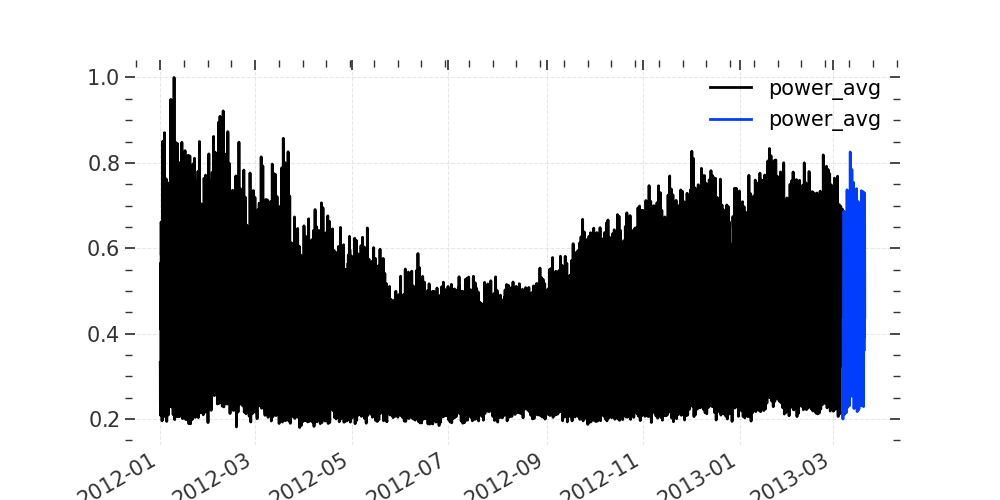

In [107]:
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape, mape, mase
from sklearn.preprocessing import MaxAbsScaler

timestamp = '2013-03-07'

train, test = target_orig.split_before(pd.Timestamp(timestamp))
test = test.head(168*2)

scaler = Scaler(scaler=MaxAbsScaler())
train = scaler.fit_transform(train)
test = scaler.transform(test)
target = scaler.transform(target_orig)

fig,  ax =  plt.subplots( figsize = (10,5))
train.plot(ax = ax)
test.plot(ax = ax)



## Modelling 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


naive smape train: 9.38 test: 9.08
xgb smape train: 5.34 test: 7.99
xgb_weighted smape train: 5.85 test: 7.93
ensemble models
 naive + xgb, smape = 7.92
 naive + xgb_weighted, smape = 7.96
 xgb + xgb_weighed, smape = 7.82
 xgb + xgb_weighed+naive, smape = 7.71


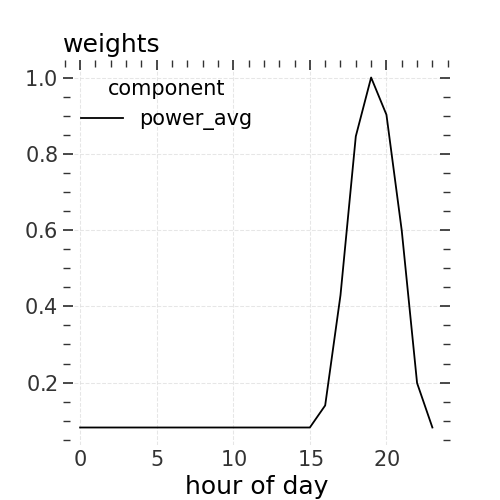

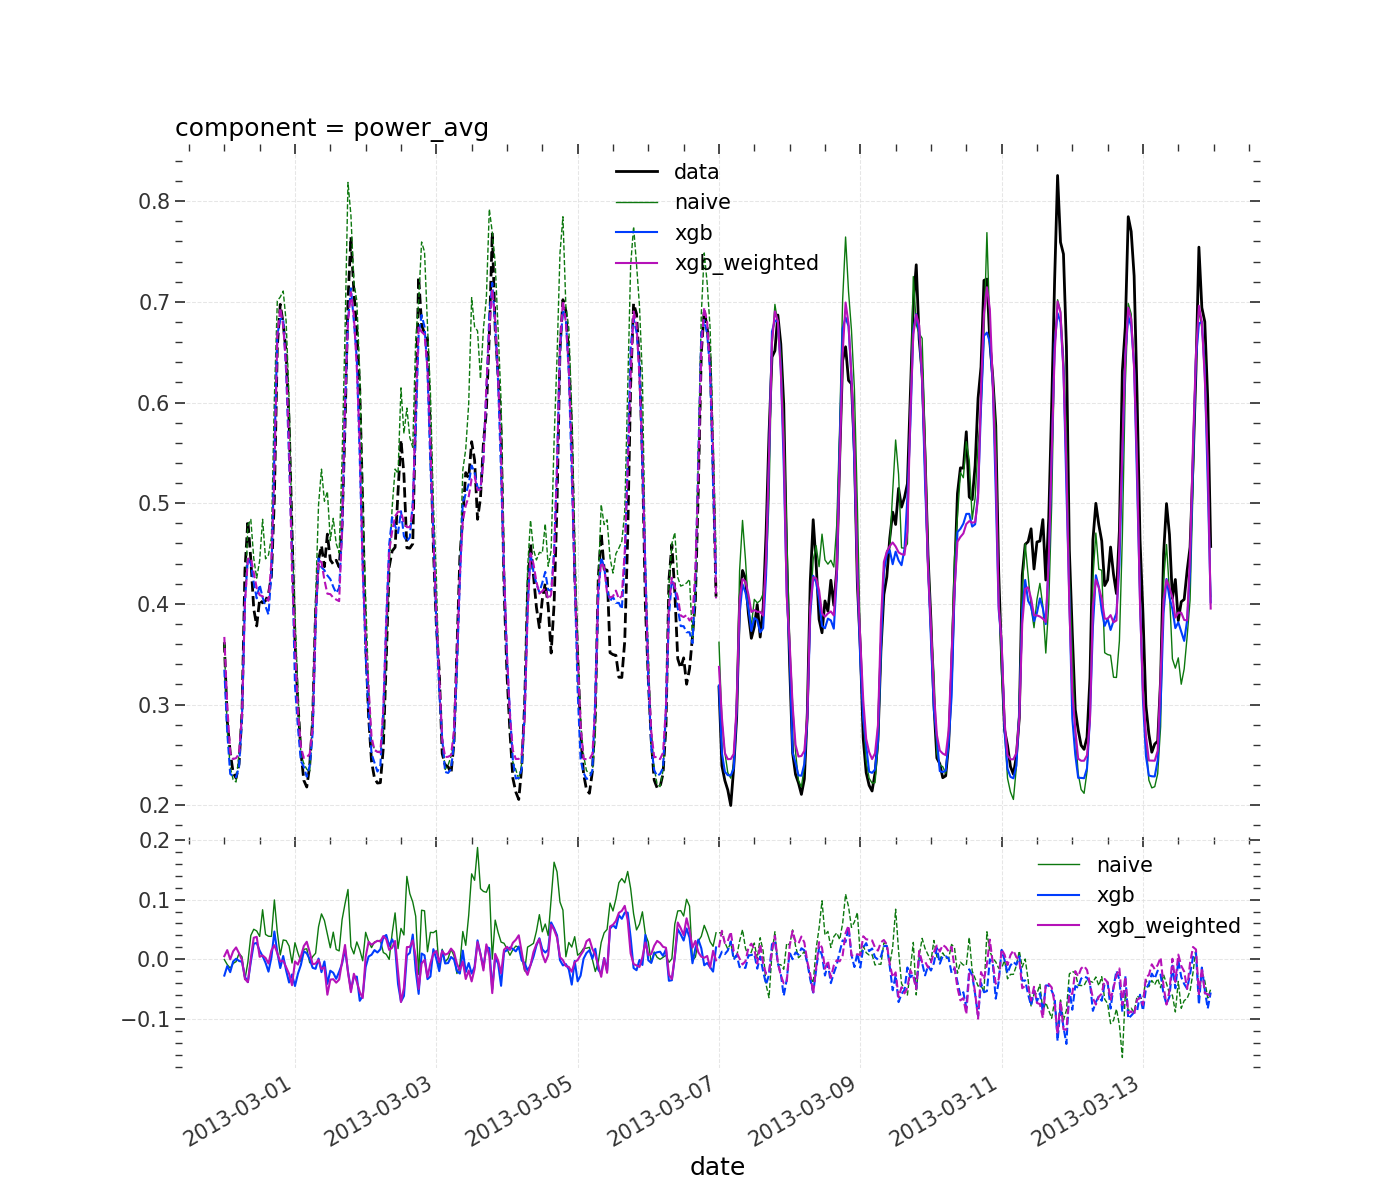

In [108]:
from darts.models import XGBModel, LinearRegressionModel

lags_horizon = list(np.hstack([np.arange(1, 25), [168]]))
lags_horizon = [int(x) for x in lags_horizon]
lags_horizon_past = [-int(x) for x in lags_horizon]
lags_horizon_past.sort()
lags_horizon_future = lags_horizon + lags_horizon_past



model_naive = LinearRegressionModel(lags_past_covariates=[-168])
model_naive.fit(train, past_covariates = target)
model_naive.model.coef_ = np.array([[1.0]])
model_naive.model.intercept_=0.0




cov_args = {"future_covariates": [datetime_covatiates,hodidays_covariates],
        "past_covariates": [twitter_covariate],}

xgb_args = {'learning_rate' : 0.065, 'n_estimators': 350, 'max_depth': 3, 'verbosity': 0, 'n_jobs': 4}
model = XGBModel(lags_future_covariates = lags_horizon_future , lags_past_covariates=lags_horizon_past,
                              **xgb_args  )                                
model.fit(train, **cov_args)


xgb_args_weighted = {'n_estimators': 300, 'learning_rate' : 0.01}
model_weighted = XGBModel(lags_future_covariates = lags_horizon_future , lags_past_covariates=lags_horizon_past,
                              **xgb_args_weighted  )    
weights = np.ones(len(train))*1
weights = weights[168:] #CHECK THIS. 168 is the max lag
weights_indeces = train.time_index
weights_indeces = weights_indeces[168:]

load_prof = train.pd_dataframe().groupby(train.pd_dataframe().index.hour).mean()
load_prof = load_prof/np.max(load_prof, axis = 0)
load_prof = load_prof.clip(0.7)
load_prof = load_prof**7
fig,  ax =  plt.subplots( figsize = (5,5))
load_prof.plot(ax = ax)
ax.set_title('weights')
ax.set_xlabel('hour of day')

for i in range(len(weights)):
        weights[i] = load_prof.loc[weights_indeces[i].hour].values[0]

model_weighted.fit(train, sample_weight = weights , **cov_args)



horizon = 24*7 #how many hours ahead


model_params_dict = {'naive': {'model': model_naive, 'label': 'naive', 'color': 'C4', 'lw': 1},
        'xgb': {'model': model, 'label': 'xgb', 'color': 'C1', 'lw': 1.5},
        'xgb_weighted': {'model': model_weighted, 'label': 'xgb_weighted', 'color': 'C2', 'lw': 1.5},

        }




fig, axs =  plt.subplots(nrows=2, ncols = 1, sharex = True, gridspec_kw = {'hspace':0, 'height_ratios': [3,1]}, figsize = (14,12))
ax, ax_weights = axs
test.head(horizon).plot(ax = ax, label = 'data', lw = 2, alpha = 0.1, color = 'k')
train.tail(horizon).plot(ax = ax, label = '_train', lw = 2, alpha = 0.1, color = 'k', ls = '--')


for model_name, model_params in model_params_dict.items():
        model = model_params['model']
        label = model_params['label']
        color = model_params['color']
        lw = model_params['lw']
        pred_test = model.predict(horizon, train)
        pred_train = model.predict(horizon, train.head(-horizon), )

        model_params_dict[model_name]['pred_test'] = pred_test
        model_params_dict[model_name]['pred_train'] = pred_train

        pred_test.plot(label = label, lw = lw, color = color, ax = ax)
        pred_train.plot(label = '_'+label, lw = lw, color = color, ls = '--', ax = ax)

        (pred_train-train.tail(horizon)).plot(ax = ax_weights, label = label, lw = lw, alpha = 0.5, color = color,)
        (pred_test - test.head(horizon)).plot(ax = ax_weights, label = '_test', lw = lw, alpha = 0.5, color = color, ls = '--')

        mape_train = smape(pred_train, train.tail(horizon))
        mape_test = smape(pred_test, test.head(horizon))

        print(f'{label} smape train: {mape_train:.2f} test: {mape_test:.2f}')


print('ensemble models')

print(f" naive + xgb, smape = {smape((model_params_dict['naive']['pred_test']+model_params_dict['xgb']['pred_test'])/2, test.head(horizon)):.2f}")
print(f" naive + xgb_weighted, smape = {smape((model_params_dict['naive']['pred_test']+model_params_dict['xgb_weighted']['pred_test'])/2, test.head(horizon)):.2f}")
print(f" xgb + xgb_weighed, smape = {smape((model_params_dict['xgb']['pred_test']+model_params_dict['xgb_weighted']['pred_test'])/2, test.head(horizon)):.2f}")
print(f" xgb + xgb_weighed+naive, smape = {smape((model_params_dict['xgb']['pred_test']+model_params_dict['xgb_weighted']['pred_test']+model_params_dict['naive']['pred_test'])/3, test.head(horizon)):.2f}")




ax.legend()
ax_weights.legend()

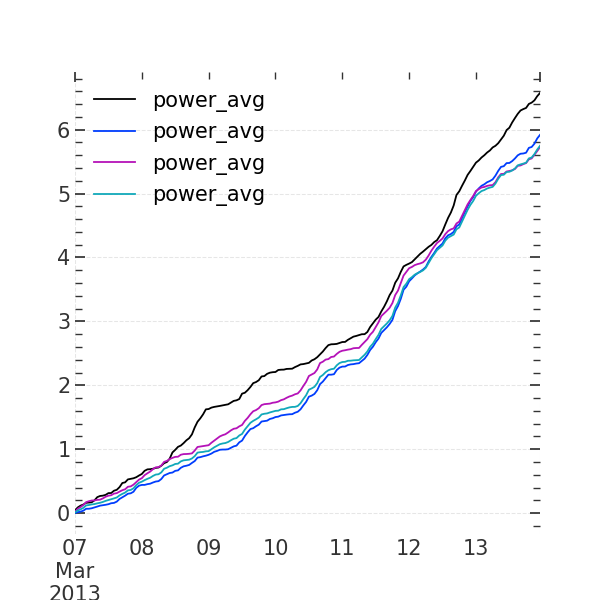

In [109]:
fig,  ax =  plt.subplots( figsize = (6,6))
(model_params_dict['naive']['pred_test']- test.head(horizon)).pd_dataframe().abs().cumsum().plot(ax=  ax, label = 'naive')
(model_params_dict['xgb']['pred_test']- test.head(horizon)).pd_dataframe().abs().cumsum().plot(ax=  ax, label = 'xgb')
(model_params_dict['xgb_weighted']['pred_test']- test.head(horizon)).pd_dataframe().abs().cumsum().plot(ax=  ax, label = 'xgb_weighted')
( (model_params_dict['xgb']['pred_test']+model_params_dict['xgb_weighted']['pred_test'])/2- test.head(horizon)).pd_dataframe().abs().cumsum().plot(ax=  ax, label = 'xgb_weighted')

ax.legend()